<a href="https://colab.research.google.com/github/DanAkarca/modular_experts/blob/main/testing_varied_architectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Parameter counts:
Homogeneous: 1039
Modular Homogeneous: 1056
Modular Heterogeneous: 1122


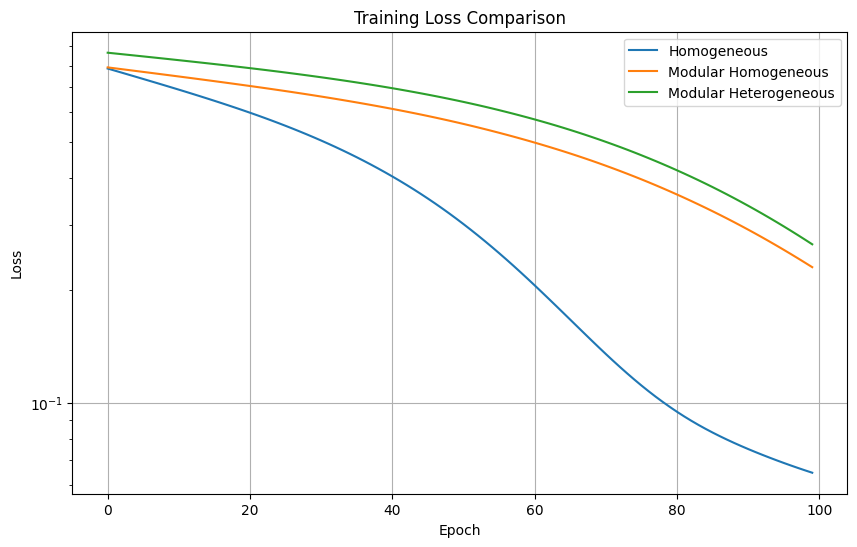


Predictions for Homogeneous:


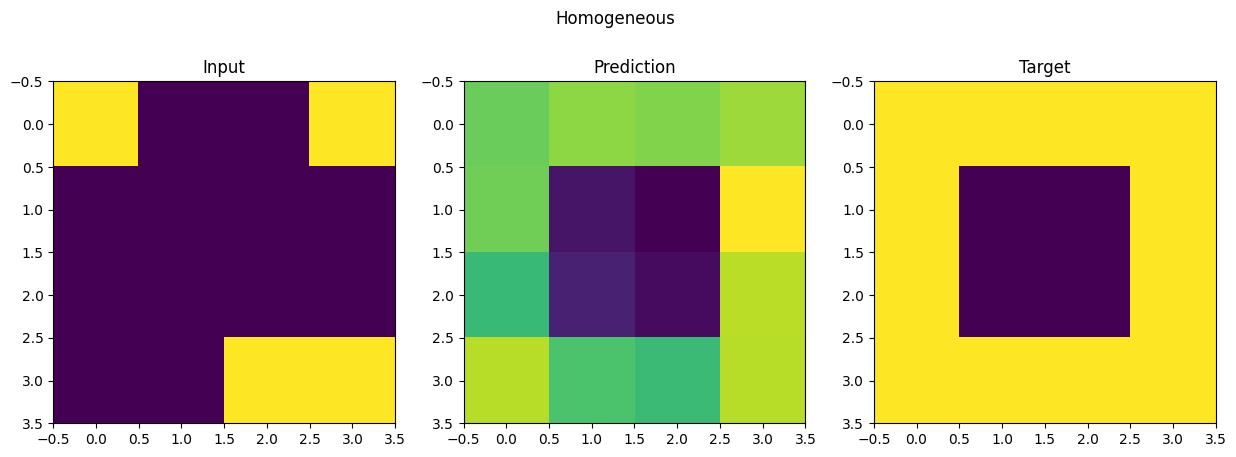


Predictions for Modular Homogeneous:


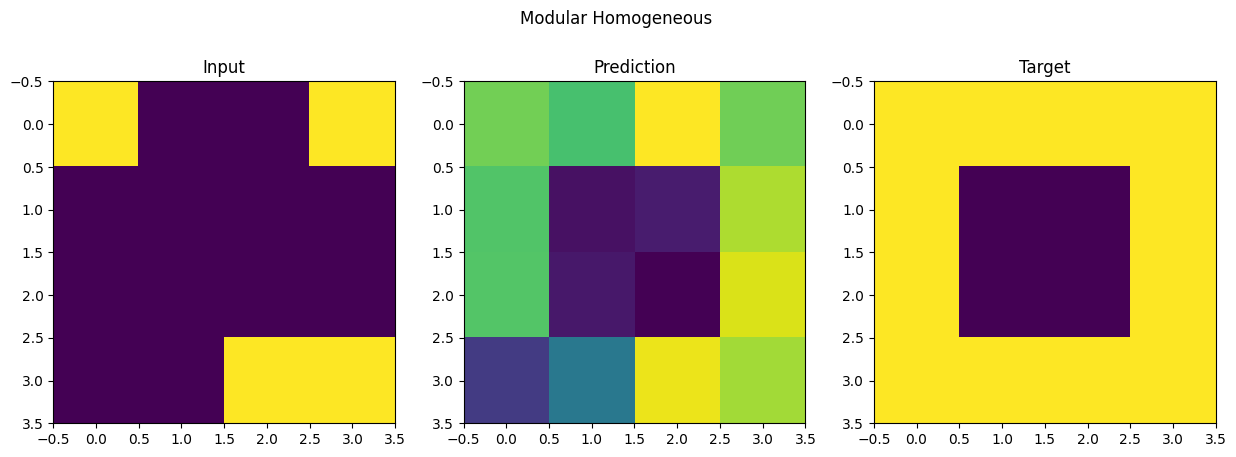


Predictions for Modular Heterogeneous:


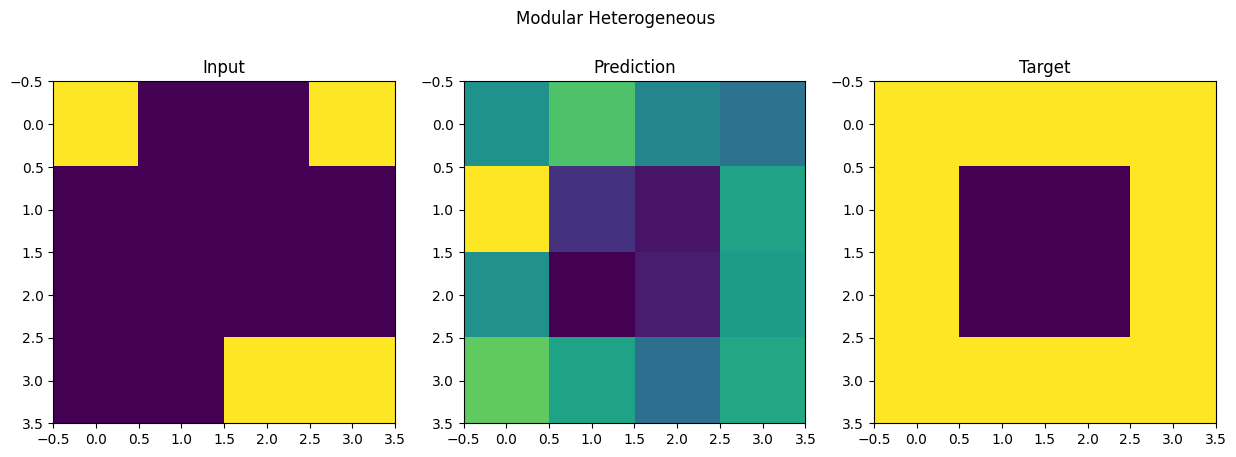

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple

class BaseExpert(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
        self.param_count = sum(p.numel() for p in self.parameters())

    def forward(self, x):
        return self.net(x)

class HomogeneousNetwork(nn.Module):
    def __init__(self, input_size: int, total_params: int):
        super().__init__()
        # Calculate hidden size to match total_params
        self.hidden_size = total_params // (2 * input_size)  # Factor of 2 for two layers
        self.expert = BaseExpert(input_size, self.hidden_size, input_size)

    def forward(self, x):
        return self.expert(x)

class ModularHomogeneous(nn.Module):
    def __init__(self, input_size: int, total_params: int, num_experts: int):
        super().__init__()
        # Calculate hidden size for each expert to match total_params
        self.hidden_size = total_params // (2 * input_size * num_experts)
        self.num_experts = num_experts
        self.input_size = input_size

        self.experts = nn.ModuleList([
            BaseExpert(input_size, self.hidden_size, input_size)
            for _ in range(num_experts)
        ])
        self.router = nn.Linear(input_size, num_experts)

    def forward(self, x):
        batch_size = x.shape[0] if len(x.shape) > 1 else 1
        if len(x.shape) == 1:
            x = x.unsqueeze(0)

        # Compute routing weights [batch_size, num_experts]
        routing_weights = torch.softmax(self.router(x), dim=-1)

        # Get outputs from each expert [num_experts, batch_size, output_size]
        expert_outputs = torch.stack([expert(x) for expert in self.experts])

        # Reshape routing weights to [batch_size, num_experts, 1]
        routing_weights = routing_weights.unsqueeze(-1)

        # Permute expert outputs to [batch_size, num_experts, output_size]
        expert_outputs = expert_outputs.permute(1, 0, 2)

        # Combine outputs [batch_size, output_size]
        output = torch.sum(routing_weights * expert_outputs, dim=1)

        return output.squeeze(0) if batch_size == 1 else output

class ModularHeterogeneous(nn.Module):
    def __init__(self, input_size: int, total_params: int, expert_ratios: List[float]):
        super().__init__()
        self.input_size = input_size
        self.num_experts = len(expert_ratios)

        # Calculate expert sizes based on ratios
        total_ratio = sum(expert_ratios)
        expert_sizes = [int((ratio/total_ratio) * total_params // (2 * input_size))
                       for ratio in expert_ratios]

        self.experts = nn.ModuleList([
            BaseExpert(input_size, size, input_size)
            for size in expert_sizes
        ])
        self.router = nn.Linear(input_size, self.num_experts)

    def forward(self, x):
        batch_size = x.shape[0] if len(x.shape) > 1 else 1
        if len(x.shape) == 1:
            x = x.unsqueeze(0)

        routing_weights = torch.softmax(self.router(x), dim=-1)
        expert_outputs = torch.stack([expert(x) for expert in self.experts])

        routing_weights = routing_weights.unsqueeze(-1)
        expert_outputs = expert_outputs.permute(1, 0, 2)

        output = torch.sum(routing_weights * expert_outputs, dim=1)
        return output.squeeze(0) if batch_size == 1 else output

def generate_pattern_data(num_samples: int, grid_size: int = 4) -> Tuple[torch.Tensor, torch.Tensor]:
    """Generate simple pattern completion data"""
    inputs = []
    targets = []

    for _ in range(num_samples):
        # Create a simple square pattern
        pattern = torch.zeros((grid_size, grid_size))
        pattern[0, :] = 1  # Top edge
        pattern[-1, :] = 1  # Bottom edge
        pattern[:, 0] = 1  # Left edge
        pattern[:, -1] = 1  # Right edge

        # Create input by masking some pixels
        masked = pattern.clone()
        mask = torch.rand(grid_size, grid_size) > 0.3
        masked[mask] = 0

        inputs.append(masked.flatten())
        targets.append(pattern.flatten())

    return torch.stack(inputs), torch.stack(targets)

def train_and_evaluate(model, train_data, train_targets, epochs=100):
    """Train model and return training history"""
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.MSELoss()
    history = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(train_data)
        loss = criterion(outputs, train_targets)
        loss.backward()
        optimizer.step()
        history.append(loss.item())

    return history

def plot_results(histories: dict, title: str):
    plt.figure(figsize=(10, 6))
    for name, history in histories.items():
        plt.plot(history, label=name)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.yscale('log')
    plt.grid(True)
    plt.show()

def visualize_predictions(model, test_input, test_target, grid_size=4, title=""):
    with torch.no_grad():
        prediction = model(test_input)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(title)

    axes[0].imshow(test_input.reshape(grid_size, grid_size))
    axes[0].set_title('Input')

    axes[1].imshow(prediction.reshape(grid_size, grid_size))
    axes[1].set_title('Prediction')

    axes[2].imshow(test_target.reshape(grid_size, grid_size))
    axes[2].set_title('Target')

    plt.show()

if __name__ == "__main__":
    # Set parameters
    input_size = 16  # 4x4 grid
    total_params = 1000  # Total parameters for each model
    num_experts = 4  # Number of experts for modular networks

    # Generate data
    train_data, train_targets = generate_pattern_data(100)

    # Initialize models
    homogeneous = HomogeneousNetwork(input_size, total_params)
    mod_homogeneous = ModularHomogeneous(input_size, total_params, num_experts)

    # Expert ratios for heterogeneous model (must sum to 1.0)
    expert_ratios = [0.4, 0.3, 0.2, 0.1]  # Different sized experts
    mod_heterogeneous = ModularHeterogeneous(input_size, total_params, expert_ratios)

    # Print parameter counts
    print("Parameter counts:")
    print(f"Homogeneous: {sum(p.numel() for p in homogeneous.parameters())}")
    print(f"Modular Homogeneous: {sum(p.numel() for p in mod_homogeneous.parameters())}")
    print(f"Modular Heterogeneous: {sum(p.numel() for p in mod_heterogeneous.parameters())}")

    # Train models
    histories = {
        'Homogeneous': train_and_evaluate(homogeneous, train_data, train_targets),
        'Modular Homogeneous': train_and_evaluate(mod_homogeneous, train_data, train_targets),
        'Modular Heterogeneous': train_and_evaluate(mod_heterogeneous, train_data, train_targets)
    }

    # Plot results
    plot_results(histories, 'Training Loss Comparison')

    # Visualize predictions for each model
    test_input, test_target = generate_pattern_data(1)

    for name, model in [('Homogeneous', homogeneous),
                       ('Modular Homogeneous', mod_homogeneous),
                       ('Modular Heterogeneous', mod_heterogeneous)]:
        print(f"\nPredictions for {name}:")
        visualize_predictions(model, test_input[0], test_target[0], title=name)